In [1]:
import pickle
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


LOAD PCA TRANSFORMATION

In [2]:
with open("/home/turker/ACE-Lensing/ace_lensing/models/pca.pkl", 'rb') as f:
    pca = pickle.load(f)

LOAD SCALING

In [3]:
with open("/home/turker/ACE-Lensing/ace_lensing/models/scale.pkl", 'rb') as f:
    scale = pickle.load(f)

TRAINING DATA

In [5]:
with open("/home/turker/ACE-Lensing/ace_lensing/data/training_set.pkl", 'rb') as f:
    df = pickle.load(f)
#df = pd.read_csv("/home/turker/ACE-Lensing/ace_lensing/data/training_set.csv")
sample = 42
params = df[["Om",	"h",	"w",	"s8",	"S8",   "z"]].loc[sample].to_frame().T 
#params = df[["Om",	"h",	"w",	"s8",	"S8",   "z"]].loc[42].to_frame().T # To keep the row shape
# When you select a single row from a DataFrame using .loc[], it returns a Series, 
# which is a one-dimensional array-like object, and it gets displayed in this vertical format.
print(params)

        Om         h       w      s8       S8       z
42  0.3172  0.729293 -0.7061  0.8152  0.79279  0.7569


In [6]:
X_input_scaled = scale.transform(params)
dmatrix = xgb.DMatrix(X_input_scaled)

In [7]:
components_predictions = []
for i in range(8):  # Assuming you have 8 components/models
    model_path = f'/home/turker/ACE-Lensing/ace_lensing/models/model_comp{i}.xgb'  # Dynamically generate model name (e.g., model_comp0, model_comp1, etc.)

    model = xgb.Booster(model_file=model_path) # Load the corresponding model using the load_model function
    
    # Perform prediction with the current model
    pred = model.predict(dmatrix)
    
    # Store the predicted component
    components_predictions.append(pred)

In [8]:
components_predictions = np.array(components_predictions).reshape(1,-1)

In [9]:
pdf_std = pca.inverse_transform(components_predictions)


/tmp/ipykernel_4037173/2451847866.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf_std = pdf_std / np.trapz(pdf_std, mu_vec_std)


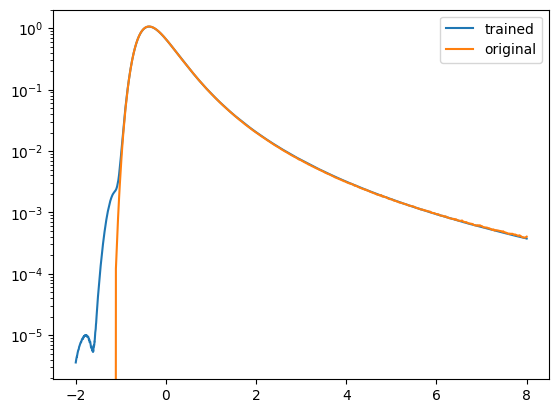

In [10]:
mu_vec_std = np.linspace(-2, 8, 5000)
pdf_std = pdf_std / np.trapz(pdf_std, mu_vec_std)
plt.plot(mu_vec_std,pdf_std[0], label="trained")
plt.plot(mu_vec_std, df["pdf"][sample], label="original")
plt.yscale("log")
plt.legend()

NON-STANDARDIZING

In [13]:
sigma_model_path = f'/home/turker/ACE-Lensing/ace_lensing/models/model_sigma.xgb'  
model_sigma = xgb.Booster(model_file=sigma_model_path) 
sigma = model_sigma.predict(dmatrix)
mean_model_path = f'/home/turker/ACE-Lensing/ace_lensing/models/model_mean.xgb'  
model_mean = xgb.Booster(model_file=mean_model_path) 
mean = model_mean.predict(dmatrix)

mu_vec = mu_vec_std * sigma + mean
pdf_non_std = pdf_std / sigma
pdf = pdf_non_std / np.trapz(pdf_non_std, mu_vec)





/tmp/ipykernel_2672761/1234975192.py:10: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf = pdf_non_std / np.trapz(pdf_non_std, mu_vec)


In [14]:
mu_test = df["mu_vec"][sample] * np.sqrt(df["var"][sample]) +df["mean"][sample]
pdf_test = df["pdf"][sample] / np.sqrt(df["var"][sample])
pdf_test = pdf_test / np.trapz(pdf_test, mu_test)

/tmp/ipykernel_2672761/3112100200.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf_test = pdf_test / np.trapz(pdf_test, mu_test)


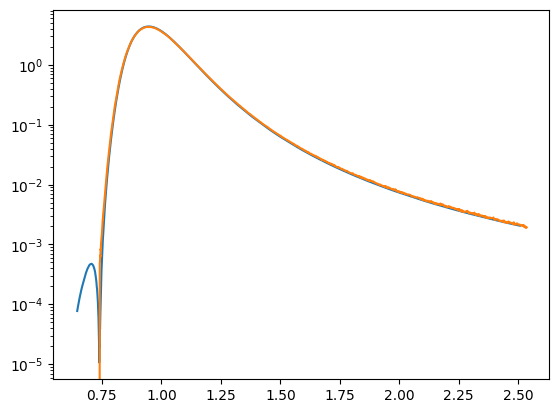

In [15]:
plt.plot(mu_vec,pdf[0])
plt.plot(mu_test, pdf_test)
plt.yscale("log")